In [1]:
import dask
import dask_awkward as dak
import mplhep as hep
import numpy as np
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp import TagNProbeFromNanoAOD, TagNProbeFromNTuples
from egamma_tnp.plot import plot_efficiency
from egamma_tnp.utils import convert_nd_mll_hists_to_1d_hists, create_hists_root_file_for_fitter

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

egamma_tnp.config.set(
    "ptbins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

In [2]:
help(TagNProbeFromNTuples)

Help on class TagNProbeFromNTuples in module egamma_tnp.ntuple_efficiency:

class TagNProbeFromNTuples(builtins.object)
 |  TagNProbeFromNTuples(fileset, filter, *, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, cutbased_id=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fileset, filter, *, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, cutbased_id=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False)
 |      Tag and Probe efficiency from E/Gamma NTuples
 |      
 |      Parameters
 |      ----------
 |          fileset: dict
 |              The fileset to calculate the trigger efficiencies for.
 |          filter: str
 |              The name of the filter to calculate the ef

In [3]:
help(TagNProbeFromNanoAOD)

Help on class TagNProbeFromNanoAOD in module egamma_tnp.nanoaod_efficiency:

class TagNProbeFromNanoAOD(builtins.object)
 |  TagNProbeFromNanoAOD(fileset, for_trigger, *, filter='None', trigger_pt=None, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, filterbit=None, cutbased_id=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False, hlt_filter=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fileset, for_trigger, *, filter='None', trigger_pt=None, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, filterbit=None, cutbased_id=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False, hlt_filter=None)
 |      Tag and Probe efficiency from NanoAOD and EGamma NanoAOD.
 |      Can only perform trigger efficiencies at the moment.
 |      
 | 

In [4]:
client = Client(dashboard_address=":12345")

In [5]:
fileset = {"Run2023": {"files": {"../tnptuples/data_EGamma_Run2023.root": "tnpEleTrig/fitter_tree"}}}

fileset_available, fileset_updated = preprocess(fileset, step_size=500_000, skip_bad_files=True)

In [6]:
tnp = TagNProbeFromNTuples(fileset_available, "passHltEle30WPTightGsf", use_sc_eta=True)

arrays = tnp.get_tnp_arrays(cut_and_count=True, vars=["pt", "eta"])
histograms = tnp.get_tnp_histograms(
    cut_and_count=True,
    pt_eta_phi_1d=True,
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap_loweta": [1.566, 2.0],
        "endcap_higheta": [2.0, 2.5],
    },
    plateau_cut=35,
)

arrays, histograms

({'Run2023': {'passing': dask.awkward<zip, npartitions=52>,
   'failing': dask.awkward<zip, npartitions=52>}},
 {'Run2023': {'pt': {'barrel': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='pt', label='Pt [GeV]'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills),
     'failing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='pt', label='Pt [GeV]'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills)},
    'endcap_loweta': {'passing': Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
             32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
            250., 400.]), name='p

In [7]:
arrays["Run2023"]["passing"].fields

['pt', 'eta']

In [8]:
histograms["Run2023"]["pt"]["barrel"]["passing"]

Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
        32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
       250., 400.]), name='pt', label='Pt [GeV]'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills)

In [9]:
arrays_computed, histograms_computed = dask.compute(arrays, histograms)

In [10]:
arrays_computed

{'Run2023': {'passing': <Array [{pt: 39.3, eta: -0.175}, ..., {...}] type='10960154 * {pt: float32[...'>,
  'failing': <Array [{pt: 44.3, eta: 1.03}, ..., {...}] type='6013828 * {pt: float32[par...'>}}

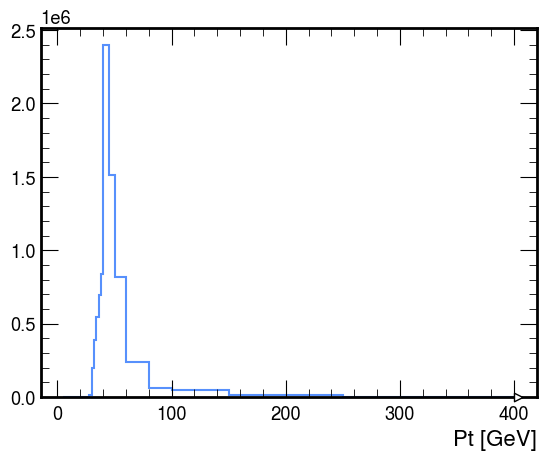

In [11]:
histograms_computed["Run2023"]["pt"]["barrel"]["passing"].plot()
plt.show()

In [12]:
out = dask.compute(tnp.get_tnp_histograms(cut_and_count=True, pt_eta_phi_1d=False, vars=["eta", "pt"]))[0]

out

{'Run2023': {'passing': Hist(
    Variable(array([-2.5   , -2.4   , -2.3   , -2.2   , -2.1   , -2.    , -1.9   ,
         -1.8   , -1.7   , -1.566 , -1.4442, -1.3   , -1.2   , -1.1   ,
         -1.    , -0.9   , -0.8   , -0.7   , -0.6   , -0.5   , -0.4   ,
         -0.3   , -0.2   , -0.1   ,  0.    ,  0.1   ,  0.2   ,  0.3   ,
          0.4   ,  0.5   ,  0.6   ,  0.7   ,  0.8   ,  0.9   ,  1.    ,
          1.1   ,  1.2   ,  1.3   ,  1.4442,  1.566 ,  1.7   ,  1.8   ,
          1.9   ,  2.    ,  2.1   ,  2.2   ,  2.3   ,  2.4   ,  2.5   ]), name='eta', label='Eta'),
    Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
          32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
         250., 400.]), name='pt', label='Pt'),
    storage=Weight()) # Sum: WeightedSum(value=1.09596e+07, variance=1.09596e+07) (WeightedSum(value=1.09602e+07, variance=1.09602e+07) with flow),
  'failing': Hist(
    Variable(array([-2.5   , -2.4   , -2.3   , -2.2 

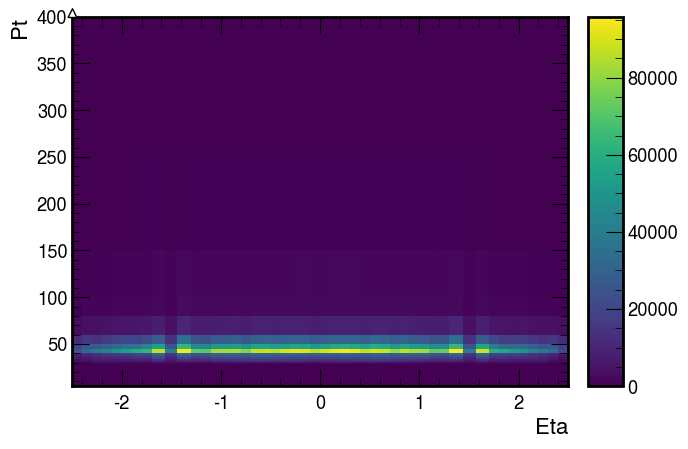

In [13]:
out["Run2023"]["passing"].plot()
plt.show()

In [14]:
print(histograms_computed["Run2023"]["pt"]["barrel"]["passing"].values(flow=True))
print()
print(out["Run2023"]["passing"][-1.4442j:1.4442j:sum, :].values(flow=True))

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.570000e+02
 1.377900e+04 1.972100e+05 3.912490e+05 5.424530e+05 6.970270e+05
 8.413190e+05 2.395841e+06 1.515179e+06 8.201380e+05 2.397650e+05
 6.487700e+04 4.823700e+04 1.663100e+04 2.968000e+03 4.410000e+02]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.570000e+02
 1.377900e+04 1.972100e+05 3.912490e+05 5.424530e+05 6.970270e+05
 8.413190e+05 2.395841e+06 1.515179e+06 8.201380e+05 2.397650e+05
 6.487700e+04 4.823700e+04 1.663100e+04 2.968000e+03 4.410000e+02]


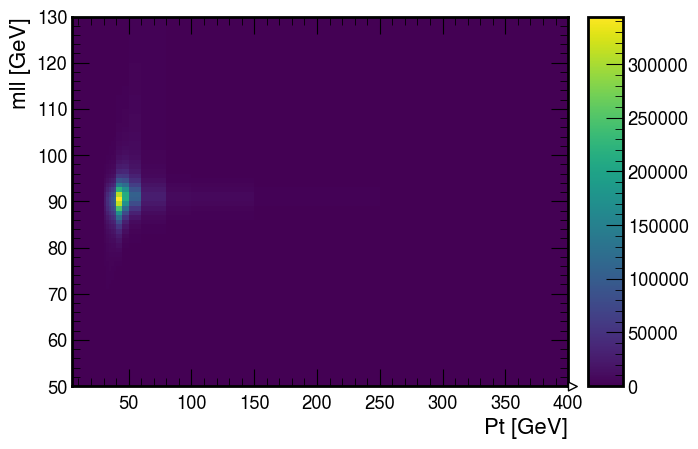

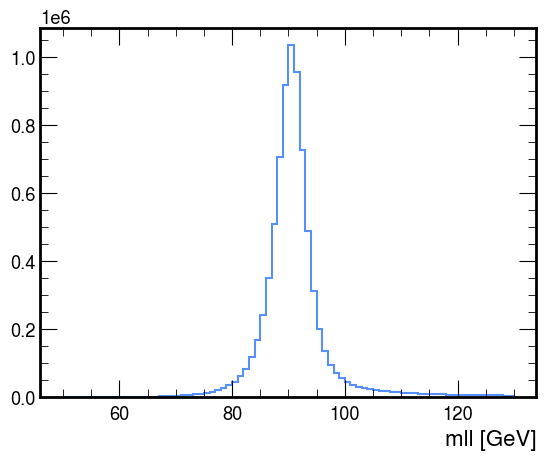

In [15]:
out = dask.compute(
    tnp.get_tnp_histograms(
        cut_and_count=False,
        pt_eta_phi_1d=True,
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
    )
)[0]

out["Run2023"]["pt"]["barrel"]["passing"].plot()
plt.show()

out["Run2023"]["pt"]["barrel"]["passing"][sum, :].plot()  # or .project("mll") instead of [sum, :]
plt.show()

hists2d = out

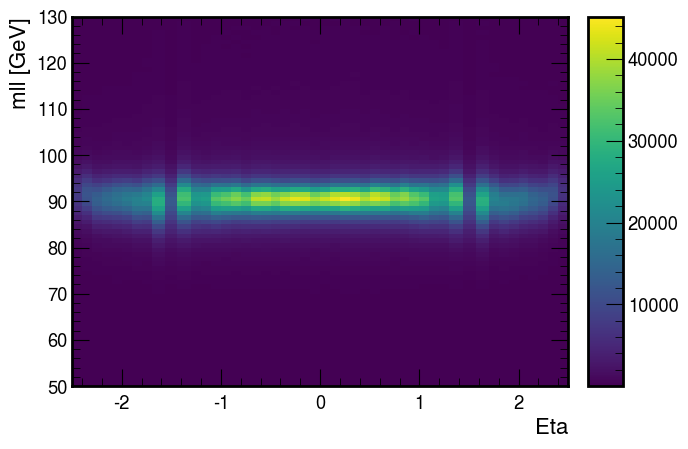

In [16]:
out = dask.compute(tnp.get_tnp_histograms(cut_and_count=False, pt_eta_phi_1d=False, vars=["eta", "pt"]))[0]

out["Run2023"]["passing"][:, sum, :].plot()
plt.show()

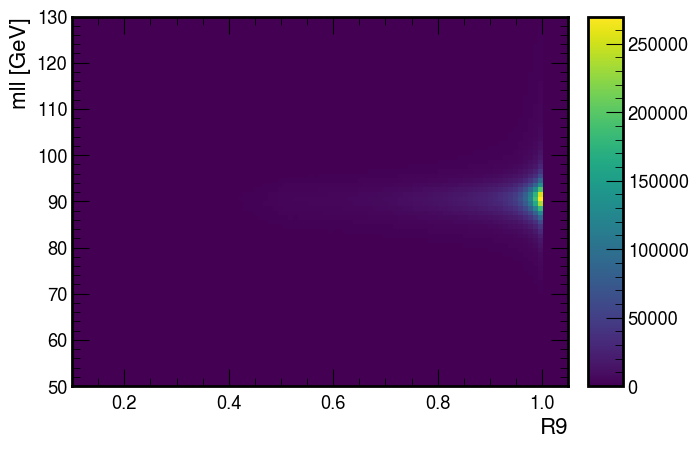

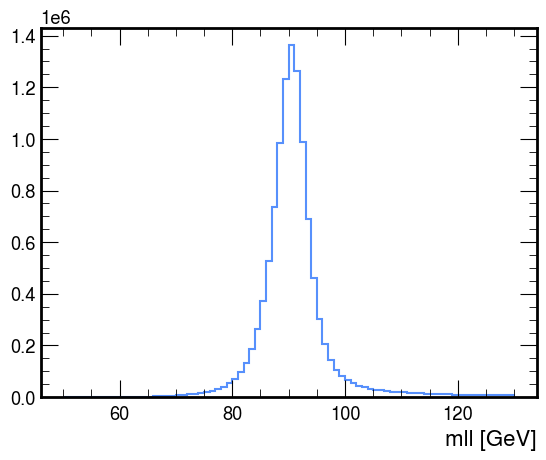

In [17]:
egamma_tnp.config.set("r9bins", list(np.linspace(0.1, 1.05, 100)))

out = dask.compute(tnp.get_tnp_histograms(cut_and_count=False, pt_eta_phi_1d=False, vars=["eta", "r9"]))[0]

out["Run2023"]["passing"][sum, :, :].plot()
plt.show()

out["Run2023"]["passing"].project("mll").plot()
plt.show()

In [18]:
dak.necessary_columns(tnp.get_tnp_histograms(cut_and_count=False, pt_eta_phi_1d=False, vars=["eta", "r9"]))

{'from-uproot-801af3bc210b60d79b8d9d0489cd8682': frozenset({'el_pt',
            'el_q',
            'el_r9',
            'el_sc_eta',
            'pair_mass',
            'passHltEle30WPTightGsf',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'})}

In [19]:
egamma_tnp.config.set("ptbins", [10, 20, 35, 50, 100, 200, 500])
egamma_tnp.config.set("sc_etabins", [-2.5, -2.0, -1.566, -1.4442, -0.8, 0.0, 0.8, 1.4442, 1.566, 2.0, 2.5])

histsnd = dask.compute(tnp.get_tnp_histograms(cut_and_count=False, pt_eta_phi_1d=False, vars=["sc_eta", "pt"]))[0]
print(histsnd["Run2023"]["passing"].axes.name)
histsnd["Run2023"]["passing"][-1.4442j:1.4442j:sum, sum, :]

('sc_eta', 'pt', 'mll')


Hist(Regular(80, 50, 130, name='mll', label='mll [GeV]'), storage=Weight()) # Sum: WeightedSum(value=7.84465e+06, variance=7.84465e+06)

In [20]:
hists, bining = convert_nd_mll_hists_to_1d_hists(histsnd["Run2023"], axes=["sc_eta", "pt"])

In [21]:
hists["passing"]["sc_eta_0p00To0p80_pt_35p00To50p00"]

Hist(Regular(80, 50, 130, name='mll', label='mll [GeV]'), storage=Weight()) # Sum: WeightedSum(value=1.70959e+06, variance=1.70959e+06)

In [22]:
histsnd["Run2023"]["passing"][0j:0.8j:sum, 35j:50j:sum, :]

Hist(Regular(80, 50, 130, name='mll', label='mll [GeV]'), storage=Weight()) # Sum: WeightedSum(value=1.70959e+06, variance=1.70959e+06)

In [23]:
create_hists_root_file_for_fitter(histsnd["Run2023"], "hists.root", "bining.pkl", axes=["sc_eta", "pt"])

In [24]:
import pickle

bins = pickle.load(open("bining.pkl", "rb"))

In [25]:
files = !ls ../tnptuples/*
fileset = {}

for path in files:
    f = path.split("/")[2][:-5]
    fileset[f] = {"files": {path: "tnpEleTrig/fitter_tree"}}

fileset_available, fileset_updated = preprocess(fileset, step_size=500_000, skip_bad_files=True)

In [26]:
hlt_paths = {
    "Ele30": "passHltEle30WPTightGsf",
    "Ele32": "passHltEle32WPTightGsf",
    "Ele115": "passHltEle115CaloIdVTGsfTrkIdTGsf",
    "Ele135": "passHltEle135CaloIdVTGsfTrkIdTGsf",
    "Ele23Ele12Leg1": "passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match",
    "Ele23Ele12Leg2": "passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2",
    "DoubleEle33SeededLeg": "passHltDoubleEle33CaloIdLMWSeedLegL1match",
    "DoubleEle33UnseededLeg": "passHltDoubleEle33CaloIdLMWUnsLeg",
}

plateau_cuts = {
    "Ele30": 35,
    "Ele32": 35,
    "Ele115": 120,
    "Ele135": 140,
    "Ele23Ele12Leg1": 25,
    "Ele23Ele12Leg2": 15,
    "DoubleEle33SeededLeg": 35,
    "DoubleEle33UnseededLeg": 35,
}

triggers = {}

for name, path in hlt_paths.items():
    triggers[name] = TagNProbeFromNTuples(fileset_available, path, cutbased_id="passingCutBasedTight122XV1")

triggers

{'Ele30': TagNProbeFromNTuples(passHltEle30WPTightGsf, Number of files: 20, Golden JSON: None),
 'Ele32': TagNProbeFromNTuples(passHltEle32WPTightGsf, Number of files: 20, Golden JSON: None),
 'Ele115': TagNProbeFromNTuples(passHltEle115CaloIdVTGsfTrkIdTGsf, Number of files: 20, Golden JSON: None),
 'Ele135': TagNProbeFromNTuples(passHltEle135CaloIdVTGsfTrkIdTGsf, Number of files: 20, Golden JSON: None),
 'Ele23Ele12Leg1': TagNProbeFromNTuples(passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match, Number of files: 20, Golden JSON: None),
 'Ele23Ele12Leg2': TagNProbeFromNTuples(passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2, Number of files: 20, Golden JSON: None),
 'DoubleEle33SeededLeg': TagNProbeFromNTuples(passHltDoubleEle33CaloIdLMWSeedLegL1match, Number of files: 20, Golden JSON: None),
 'DoubleEle33UnseededLeg': TagNProbeFromNTuples(passHltDoubleEle33CaloIdLMWUnsLeg, Number of files: 20, Golden JSON: None)}

In [27]:
%%time

to_compute = {}

for name, trigger in triggers.items():
    if name == "Ele115" or name == "Ele135":
        egamma_tnp.config.set(
            "ptbins",
            [
                5,
                10,
                15,
                20,
                22,
                26,
                28,
                30,
                32,
                34,
                36,
                38,
                40,
                45,
                50,
                60,
                80,
                100,
                105,
                110,
                115,
                120,
                125,
                130,
                135,
                140,
                145,
                150,
                200,
                250,
                300,
                350,
                400,
            ],
        )
    else:
        egamma_tnp.config.set(
            "ptbins",
            [
                5,
                10,
                12,
                14,
                16,
                18,
                20,
                23,
                26,
                28,
                30,
                32,
                34,
                36,
                38,
                40,
                45,
                50,
                60,
                80,
                100,
                150,
                250,
                400,
            ],
        )
    plateau_cut = plateau_cuts[name]
    to_compute[name] = trigger.get_tnp_histograms(
        uproot_options={"allow_read_errors_with_report": True},
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=plateau_cut,
    )


dak.necessary_columns(to_compute)

CPU times: user 1min 25s, sys: 2.04 s, total: 1min 28s
Wall time: 1min 27s


{'from-uproot-8f02713d64b227b2103e135af8d12270': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'el_q',
            'pair_mass',
            'passHltDoubleEle33CaloIdLMWSeedLegL1match',
            'passHltDoubleEle33CaloIdLMWUnsLeg',
            'passHltEle115CaloIdVTGsfTrkIdTGsf',
            'passHltEle135CaloIdVTGsfTrkIdTGsf',
            'passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match',
            'passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2',
            'passHltEle30WPTightGsf',
            'passHltEle32WPTightGsf',
            'passingCutBasedTight122XV1',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'}),
 'from-uproot-27070ea86204a853865d2a336bb82b16': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'el_q',
            'pair_mass',
            'passHltDoubleEle33CaloIdLMWSeedLegL1match',
            'passHltDoubleEle33CaloIdLMWUnsLeg',
            'passHltEle115CaloIdVTGsfTrkIdTGsf',
      

In [28]:
%%time

out = dask.compute(to_compute)[0]

2024-04-22 01:11:13,892 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:16,450 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:17,214 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:20,550 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:25,818 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:39,618 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:43,682 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-22 01:11:48,607 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 2min 53s, sys: 6.24 s, total: 2min 59s
Wall time: 3min 27s


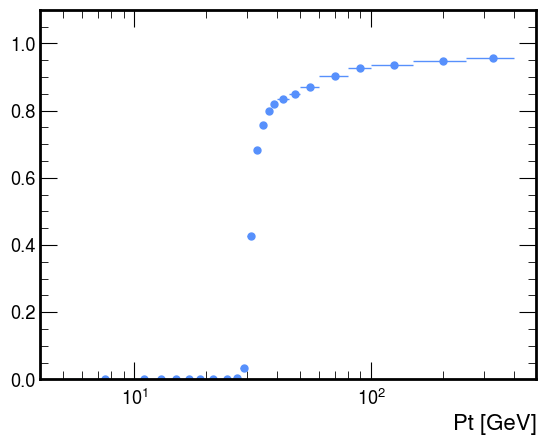

In [29]:
plot_efficiency(
    out["Ele30"][0]["data_EGamma_Run2023"]["pt"]["barrel"]["passing"],
    out["Ele30"][0]["data_EGamma_Run2023"]["pt"]["barrel"]["failing"],
)

plt.xscale("log")
plt.ylim(0, 1.1)
plt.show()